# Software Vulnerability Detection using Deep Learning (Experiment Replication)

In [1]:
#!install unrar

In [2]:
# !pip install transformers

In [3]:
#!git clone https://github.com/danzz006/AVD.git

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# from torch.optim import AdamW as AdamW
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import torch.nn.functional as F

import tensorflow as tf
# import mlflow


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Available device: ", device)

c:\Users\Administrator\anaconda3\envs\avdbert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available device:  cuda:0


In [5]:
torch.cuda.is_available()

True

In [6]:
%cd AVD

[WinError 2] The system cannot find the file specified: 'AVD'
c:\Users\Administrator\Downloads\AVD


In [7]:
#!unrar e DataSet1000.rar

In [8]:
#data=pd.read_csv("DataSet1000.csv")

In [9]:
#data.tail()

In [10]:
os.getcwd()

'c:\\Users\\Administrator\\Downloads\\AVD'

In [11]:
data=pd.read_csv("DataSet_whnv.csv")

In [12]:
data.head()

,Name,Category,Impact,CWE-749,CWE-312,CWE-295,CWE-276,CWE-327,CWE-330,CWE-200,CWE-89,CWE-919,CWE-649,CWE-250
0,"public void addJavascriptObject(Object obj, St...",0,warning,1,0,0,0,0,0,0,0,0,0,0
1,public void initialize() \n setPlacemen...,0,warning,1,0,0,0,0,0,0,0,0,0,0
2,public void initialize() \n setPlacemen...,0,warning,1,0,0,0,0,0,0,0,0,0,0
3,public void displayRichMedia(final JSONObject ...,0,warning,1,0,0,0,0,0,0,0,0,0,0
4,this.webView.addJavascriptInterface(this.jsBri...,0,warning,1,0,0,0,0,0,0,0,0,0,0


In [13]:
for dataset in [data]:
    for col in range(2,14):
            dataset.iloc[:,col] = dataset.iloc[:,col].map({'False':0, 'True':1,False:0, True:1,'1':1,'0':0,'1.0':1,'0.0':0, 'NV':1, 'warning':0, 'high': 0})


In [14]:
data.head()

,Name,Category,Impact,CWE-749,CWE-312,CWE-295,CWE-276,CWE-327,CWE-330,CWE-200,CWE-89,CWE-919,CWE-649,CWE-250
0,"public void addJavascriptObject(Object obj, St...",0,0,1,0,0,0,0,0,0,0,0,0,0
1,public void initialize() \n setPlacemen...,0,0,1,0,0,0,0,0,0,0,0,0,0
2,public void initialize() \n setPlacemen...,0,0,1,0,0,0,0,0,0,0,0,0,0
3,public void displayRichMedia(final JSONObject ...,0,0,1,0,0,0,0,0,0,0,0,0,0
4,this.webView.addJavascriptInterface(this.jsBri...,0,0,1,0,0,0,0,0,0,0,0,0,0


In [15]:
del data['Category']


for col in data:
    if col != "Name":
        if data[col].value_counts()[1] < 1000:
            del data[col]
     

In [16]:
data.head()

,Name,Impact,CWE-312,CWE-276,CWE-327,CWE-200,CWE-89
0,"public void addJavascriptObject(Object obj, St...",0,0,0,0,0,0
1,public void initialize() \n setPlacemen...,0,0,0,0,0,0
2,public void initialize() \n setPlacemen...,0,0,0,0,0,0
3,public void displayRichMedia(final JSONObject ...,0,0,0,0,0,0
4,this.webView.addJavascriptInterface(this.jsBri...,0,0,0,0,0,0


In [17]:
del data['CWE-276']
del data['CWE-312']
del data['CWE-327']
del data['CWE-200']
del data['CWE-89']
data.to_csv("DataSet_bbnew.csv",index=False)

In [18]:
data.head()

,Name,Impact
0,"public void addJavascriptObject(Object obj, St...",0
1,public void initialize() \n setPlacemen...,0
2,public void initialize() \n setPlacemen...,0
3,public void displayRichMedia(final JSONObject ...,0
4,this.webView.addJavascriptInterface(this.jsBri...,0


In [19]:
print(data['Impact'].value_counts())

1    15999
0    15973
Name: Impact, dtype: int64


In [20]:
shuffled = data.sample(frac=1).reset_index(drop=True) # for randomizing data

In [21]:
shuffled.head()

,Name,Impact
0,"public long update(String userName, String pas...",0
1,public synchronized List<Identity> getIdentiti...,1
2,"private static final String OPT_OUT_KEY = ""opt...",0
3,public final WebResourceResponse shouldInterce...,0
4,public void reload() \n if (!(this.mSp ...,0


In [22]:
shuffled[shuffled.columns[0:5]]

,Name,Impact
0,"public long update(String userName, String pas...",0
1,public synchronized List<Identity> getIdentiti...,1
2,"private static final String OPT_OUT_KEY = ""opt...",0
3,public final WebResourceResponse shouldInterce...,0
4,public void reload() \n if (!(this.mSp ...,0
...,...,...
31967,"public static void a(boolean z, String str, Ob...",1
31968,public void onCreate(Bundle savedInstanceState...,0
31969,public final String toString() \n if (t...,0
31970,private final WebViewClient U = new WebViewCli...,0


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x_tmp, x_test, y_tmp, y_test = train_test_split(shuffled["Name"], shuffled[shuffled.columns[1:5]], test_size=0.2, random_state=42)

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

In [26]:
y_train.value_counts()

Impact
0         6401
1         6387
dtype: int64

In [27]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [28]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [29]:
# sample_txt = x_train[164212]

In [30]:
# sample_txt

In [31]:
# sample_txt = sample_txt.replace("\n", " ")
# sample_txt = sample_txt.replace(";", "")

In [32]:
# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.convert_tokens_to_ids(tokens)
# print(f' Sentence: {sample_txt}')
# print(f'   Tokens: {tokens}')
# print(f'Token IDs: {token_ids}')

In [33]:
# encoding = tokenizer.encode_plus(
#   sample_txt,
#   truncation=True,
#   max_length=32,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   padding='max_length',
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )
# encoding.keys()

In [34]:
# print(len(encoding['input_ids'][0]))
# encoding['input_ids'][0]

In [35]:
# print(len(encoding['attention_mask'][0]))
# encoding['attention_mask']

In [36]:
# tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [37]:
# token_lens = []
# for txt in data.Name:
#   tokens = tokenizer.encode(txt, truncation=True, max_length=512)
#   token_lens.append(len(tokens))

In [38]:
# sns.histplot(token_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

In [39]:
MAX_LEN = 512

In [40]:
class SWVulnerabilityDataset(Dataset):
    
  def __init__(self, code, targets, tokenizer, max_len):
    self.code = code
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.code)

  def __getitem__(self, item):
    code = str(self.code[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      code,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'code_text': code,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [41]:
def create_data_loader(code, targets, tokenizer, max_len, batch_size):
  ds = SWVulnerabilityDataset(
    code=code,
    targets=targets,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [42]:
BATCH_SIZE = 5
train_data_loader = create_data_loader(x_train.to_numpy(), y_train.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(x_val.to_numpy(), y_val.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(x_test.to_numpy(), y_test.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [43]:
a = next(iter(train_data_loader))

In [44]:
# data = next(iter(train_data_loader))
# data.keys()

In [45]:
# print(data['input_ids'].shape)
# print(data['attention_mask'].shape)
# print(data['targets'].shape)

In [46]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# last_hidden_state, pooled_output = bert_model(
#   input_ids=encoding['input_ids'],
#   attention_mask=encoding['attention_mask']
# )[0:]

In [48]:
# last_hidden_state.shape, pooled_output.shape

In [49]:
class SWVulnerabilityClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SWVulnerabilityClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
#     self.softmax = F.softmax()
    
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0:]
    output = self.drop(pooled_output)
    return self.out(output)

In [50]:
y_train

,Impact
8482,0
24665,1
26683,0
10306,1
15617,0
...,...
23758,0
19011,0
29956,1
27396,1


In [51]:
model = SWVulnerabilityClassifier(len(y_train.columns))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
# del model

In [53]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [54]:
EPOCHS = 500
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn = nn.BCELoss().to(device)

c:\Users\Administrator\anaconda3\envs\avdbert\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
device

device(type='cuda', index=0)

In [56]:
# model = model.train()

In [57]:
# batch_data = next(iter(train_data_loader))

In [58]:
# losses = []
# correct_predictions = 0

# history = defaultdict(list)

# for epoch in range(EPOCHS):
#     model = model.train()
#     batch_data = next(iter(train_data_loader))
#     input_ids = batch_data["input_ids"].to(device)
#     attention_mask = batch_data["attention_mask"].to(device)
#     targets = batch_data["targets"].float().to(device)
#     # targets = targets.squeeze()
    
#     outputs = model(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     _, preds = torch.max(outputs, dim=1)
#     loss = loss_fn(torch.sigmoid(outputs.squeeze()), targets.squeeze())
    
#     # targets_arr = []
#     # for i in targets:
#     #     targets_arr.append(np.argmax(i.cpu()).numpy().item())
#     # targets = torch.Tensor(targets_arr).to(device)
    
#     correct_predictions += torch.sum(preds == targets.squeeze())
#     losses.append(loss.item())
#     loss.backward()
#     nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()
#     scheduler.step()
#     optimizer.zero_grad()
    
#     train_acc = correct_predictions.double() / len(train_data_loader)
#     train_loss = np.mean(losses)
#     print("*"*40)
#     print(f"Epoch: {epoch}")
#     print("Training accuracy: ", train_acc.item())
#     print("Training loss: ", train_loss)

    
#     history['train_acc'].append(train_acc.item())
#     history['train_loss'].append(train_loss)
    
#     print("Evaluating model..")
#     model = model.eval()
#     val_losses = []
#     val_correct_predictions = 0
#     with torch.no_grad():
#         val_data = next(iter(val_data_loader))
#         input_ids = val_data["input_ids"].to(device)
#         attention_mask = val_data["attention_mask"].to(device)
#         targets = val_data["targets"].float().to(device)
#         outputs = model(
#         input_ids=input_ids,
#         attention_mask=attention_mask
#         )
#         _, preds = torch.max(outputs, dim=1)
#         loss = loss_fn(torch.sigmoid(outputs.squeeze()), targets.squeeze())
        
#         # targets_arr = []
#         # for i in targets:
#         #     targets_arr.append(np.argmax(i.cpu()).numpy().item())
#         # targets = torch.Tensor(targets_arr).to(device)
        
#         val_correct_predictions += torch.sum(preds == targets.squeeze())
#         val_losses.append(loss.item())
        
#         val_acc = val_correct_predictions.double() / len(val_data_loader)
#         val_loss = np.mean(val_losses)
        
#     print("Eval accuracy: ", val_acc.item())
#     print("Eval loss: ", val_loss)
#     print("*"*40)

#     history['val_acc'].append(val_acc.item())
#     history['val_loss'].append(val_loss)
    
    

In [59]:
#torch.cuda.empty_cache()


In [60]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

In [62]:

losses = []
correct_predictions = 0

history = defaultdict(list)

for epoch in range(EPOCHS):
    model = model.train()
    batch_data = next(iter(train_data_loader))
    input_ids = batch_data["input_ids"].to(device)
    attention_mask = batch_data["attention_mask"].to(device)
    targets = batch_data["targets"].float().to(device)
    # targets = targets.squeeze()
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
   
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(torch.sigmoid(outputs.squeeze()), targets.squeeze())
    
    # targets_arr = []
    # for i in targets:
    #     targets_arr.append(np.argmax(i.cpu()).numpy().item())
    # targets = torch.Tensor(targets_arr).to(device)
    
    correct_predictions += torch.sum(preds == targets.squeeze())
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    train_acc = correct_predictions.double() / len(train_data_loader)
    train_loss = np.mean(losses)
    print("*"*40)
    print(f"Epoch: {epoch}")
    print("Training accuracy: ", train_acc.item())
    print("Training loss: ", train_loss)

    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    
    print("Evaluating model..")
    model = model.eval()
    val_losses = []
    val_correct_predictions = 0
    with torch.no_grad():
        val_data = next(iter(val_data_loader))
        input_ids = val_data["input_ids"].to(device)
        attention_mask = val_data["attention_mask"].to(device)
        targets = val_data["targets"].float().to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        # _, preds = torch.sigmoid(outputs.squeeze())
        # _, preds = torch.max(outputs.squeeze(), dim=1)
        loss = loss_fn(torch.sigmoid(outputs.squeeze()), targets.squeeze())
        
        # targets_arr = []
        # for i in targets:
        #     targets_arr.append(np.argmax(i.cpu()).numpy().item())
        # targets = torch.Tensor(targets_arr).to(device)
        
        val_correct_predictions += torch.sum(preds == targets.squeeze())
        val_losses.append(loss.item())
        
        val_acc = val_correct_predictions.double() / len(val_data_loader)
        val_loss = np.mean(val_losses)
        
    print("Eval accuracy: ", val_acc.item())
    print("Eval loss: ", val_loss)
    print("*"*40)

    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    

****************************************
Epoch: 0
Training accuracy:  0.0011727912431587178
Training loss:  0.00011585611355258152
Evaluating model..
Eval accuracy:  0.0007818608287724785
Eval loss:  3.827155828475952
****************************************
****************************************
Epoch: 1
Training accuracy:  0.0023455824863174357
Training loss:  0.00012048151620547287
Evaluating model..
Eval accuracy:  0.0007818608287724785
Eval loss:  3.8284432888031006
****************************************
****************************************
Epoch: 2
Training accuracy:  0.003518373729476153
Training loss:  0.00011075673683080822
Evaluating model..
Eval accuracy:  0.0007818608287724785
Eval loss:  3.8297760486602783
****************************************
****************************************
Epoch: 3
Training accuracy:  0.004691164972634871
Training loss:  0.00011750381599995308
Evaluating model..
Eval accuracy:  0.0007818608287724785
Eval loss:  3.8308990001678467
****

(0.0, 1.0)

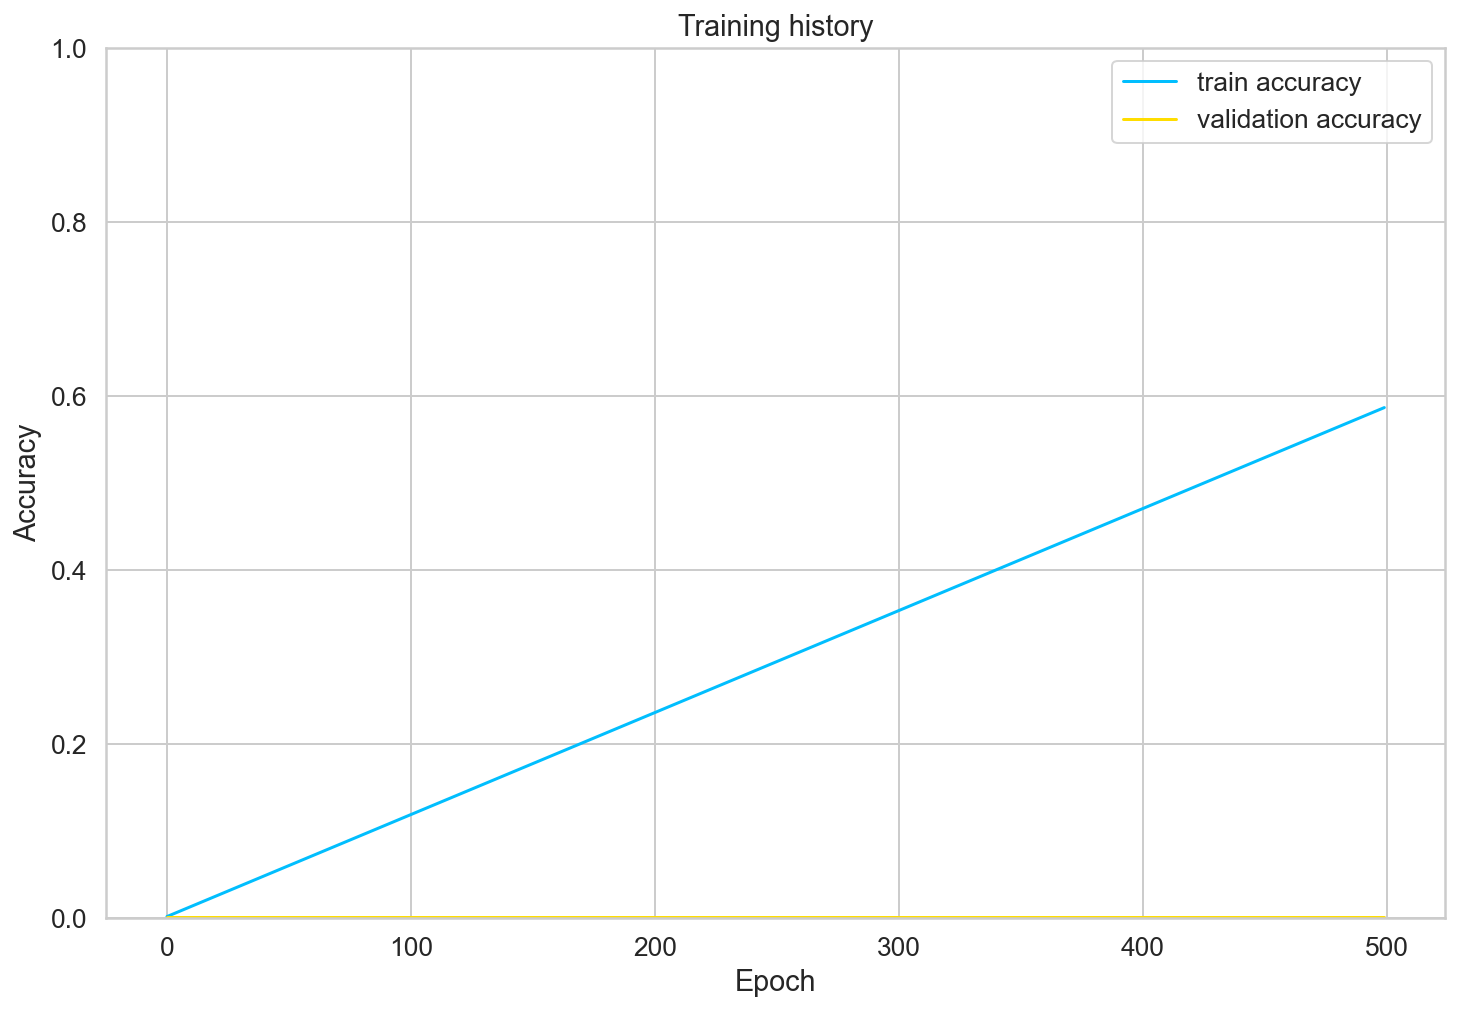

In [63]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])